<a href="https://colab.research.google.com/github/Song-Pingfan/fastMRI/blob/spf/run_zero_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-filled Solution

The `run_zero_filled.py` script creates a submission with the zero-filled
solution. This script exists as a simple baseline, only to demonstrate how to
create a submission.

To generate the zero-filled submissions, run:

```bash
python run_zero_filled.py \
    --challenge CHALLENGE \
    --data_path DATA \
    --output_path RECONS
```

where `CHALLENGE` is either `singlecoil` or `multicoil`.

For cropping the script infers the target image dimensions from the ISMRMRD header. Note that there are some issues with files that have "FLAIR_203" in their file name - there are three of these files in the test set, and they are ignored for the brain leaderboard.


In [1]:
# Check if we're running in Colab (versus local server)

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab.")
else:
  print("We're running in a local server.")


We're running Colab.


In [2]:
%pwd

'/content'

In [3]:
# If we're in Colab, mount the Google Drive, and switch to a directory that will be used,
# else we're not in Colab, get current working directory, and switch to a directory that will be used.

if IN_COLAB:
  # Mount the Google Drive (if we're in Colab)
  mount='/content/googledrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount) # drive.flush_and_unmount() # unmount google drive

  # Switch to a directory that will be used.
  import os
  ROOT = mount + "/MyDrive/Research/fastMRI-MetaAI"

else:
  # Get current working directory (if we're not in Colab)
  mount = '/homes/ps898' # mount = os.getcwd(), # os.path.dirname(ROOT) gives '/homes'
  
  # Switch to a directory that will be used.
  import os
  ROOT = mount + "/googledrive/Research/fastMRI-MetaAI"


# # Create ROOT if it doesn't exist
# os.makedirs(ROOT, exist_ok=True)

# Change to the directory
print("\nColab: Changing directory to ", ROOT)
%cd $ROOT


Colab: mounting Google drive on  /content/googledrive
Mounted at /content/googledrive

Colab: Changing directory to  /content/googledrive/MyDrive/Research/fastMRI-MetaAI
/content/googledrive/MyDrive/Research/fastMRI-MetaAI


In [4]:
%ls

banding_removal/      fastmri_examples/           multicoil_train/  setup.py
CODE_OF_CONDUCT.md    fastMRI_tutorial_spf.ipynb  multicoil_val/    tests/
CONTRIBUTING.md       fastMRI_tutorial_spf.pdf    mypy.ini
dev-requirements.txt  LICENSE.md                  README.md
fastmri/              LIST_OF_PAPERS.md           requirements.txt


In [5]:
import torch
[
torch.cuda.is_available(),
torch.cuda.device_count(),
torch.cuda.current_device(),
torch.cuda.device(0), # <torch.cuda.device at 0x7efce0b03be0>
torch.cuda.get_device_name(0) # 'GeForce GTX 950M'
]

[True, 1, 0, <torch.cuda.device at 0x7f6bd263abd0>, 'Tesla T4']

In [ ]:
# install fastmri if we are using colab.
if IN_COLAB:
    %pip install fastmri

In [50]:
"""
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import xml.etree.ElementTree as etree
from argparse import ArgumentParser
from pathlib import Path

import fastmri
import h5py
from fastmri.data import transforms
from fastmri.data.mri_data import et_query
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt

In [9]:
%pwd

'/content/googledrive/MyDrive/Research/fastMRI-MetaAI'

## test function save_zero_filled

In [79]:
# setup data path, output path, etc.
data_dir, out_dir, which_challenge = Path('./multicoil_train'), Path('./output'), 'multicoil'

In [82]:
sorted(list(data_dir.glob("*.h5")))

[PosixPath('multicoil_train/file1000142.h5'),
 PosixPath('multicoil_train/file1000167.h5'),
 PosixPath('multicoil_train/file1000250.h5'),
 PosixPath('multicoil_train/file1000317.h5')]

In [77]:
reconstructions = {}

In [94]:

# for fname in tqdm(sorted((list(data_dir.glob("*.h5"))))):
fname = sorted(list(data_dir.glob("*.h5")))[3]
print('\n', fname)

hf = h5py.File(fname, "r")
et_root = etree.fromstring(hf["ismrmrd_header"][()])
masked_kspace = transforms.to_tensor(hf["kspace"][()])

# extract target image width, height from ismrmrd header
enc = ["encoding", "encodedSpace", "matrixSize"]
crop_size = (
    int(et_query(et_root, enc + ["x"])),
    int(et_query(et_root, enc + ["y"])),
)
print(crop_size) # (640, 372)

# inverse Fourier Transform to get zero filled solution
image = fastmri.ifft2c(masked_kspace)

# check for FLAIR 203
if image.shape[-2] < crop_size[1]:
    crop_size = (image.shape[-2], image.shape[-2])

# crop input image
image = transforms.complex_center_crop(image, crop_size)

# absolute value
image = fastmri.complex_abs(image)

# apply Root-Sum-of-Squares if multicoil data
if which_challenge == "multicoil":
    image = fastmri.rss(image, dim=1)

reconstructions[fname.name] = image
print(image.shape)
hf.close()


 multicoil_train/file1000317.h5
(640, 372)
torch.Size([32, 640, 372])


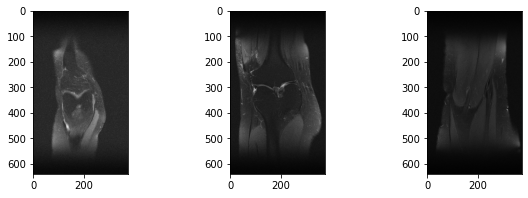

In [91]:
plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow(np.abs(image.numpy()[10]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(image.numpy()[20]), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.abs(image.numpy()[-1]), cmap='gray')
plt.show()

In [95]:
reconstructions.keys()

dict_keys(['file1000167.h5', 'file1000250.h5', 'file1000317.h5'])

In [96]:
fastmri.save_reconstructions(reconstructions, out_dir)

## read and show reconstructed MRI images

file name:  file1000167.h5 
image shape:  (30, 640, 372)


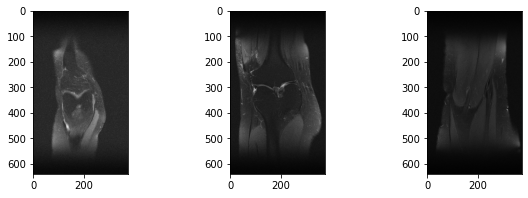

In [110]:
fnames = sorted(list(out_dir.glob("*.h5")))
fname = fnames[0]
hf = h5py.File(fname, "r") # print('Keys:', list(hf.keys())) # => Keys: ['reconstruction'] # print('Attrs:', dict(hf.attrs)) => {}
image = hf['reconstruction']

print('file name: ', fname.name, '\nimage shape: ', image.shape)

plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow(np.abs(image[10]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(image[20]), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.abs(image[-1]), cmap='gray')
plt.show()

## Original run_zero_filled.py

In [11]:
"""
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import xml.etree.ElementTree as etree
from argparse import ArgumentParser
from pathlib import Path

import fastmri
import h5py
from fastmri.data import transforms
from fastmri.data.mri_data import et_query
from tqdm import tqdm


def save_zero_filled(data_dir, out_dir, which_challenge):
    reconstructions = {}

    for fname in tqdm(list(data_dir.glob("*.h5"))):
        with h5py.File(fname, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])
            masked_kspace = transforms.to_tensor(hf["kspace"][()])

            # extract target image width, height from ismrmrd header
            enc = ["encoding", "encodedSpace", "matrixSize"]
            crop_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
            )

            # inverse Fourier Transform to get zero filled solution
            image = fastmri.ifft2c(masked_kspace)

            # check for FLAIR 203
            if image.shape[-2] < crop_size[1]:
                crop_size = (image.shape[-2], image.shape[-2])

            # crop input image
            image = transforms.complex_center_crop(image, crop_size)

            # absolute value
            image = fastmri.complex_abs(image)

            # apply Root-Sum-of-Squares if multicoil data
            if which_challenge == "multicoil":
                image = fastmri.rss(image, dim=1)

            reconstructions[fname.name] = image

    fastmri.save_reconstructions(reconstructions, out_dir)


def create_arg_parser():
    parser = ArgumentParser()

    parser.add_argument(
        "--data_path",
        type=Path,
        required=True,
        help="Path to the data",
    )
    parser.add_argument(
        "--output_path",
        type=Path,
        required=True,
        help="Path to save the reconstructions to",
    )
    parser.add_argument(
        "--challenge",
        type=str,
        required=True,
        help="Which challenge",
    )

    return parser


if __name__ == "__main__":
    args = create_arg_parser().parse_args()
    save_zero_filled(args.data_path, args.output_path, args.challenge)


## show 3D figure

In [154]:
# note, image has the type of h5py._hl.dataset.Dataset, that is h5py 'Dataset' object. 
# In contrast, image[()] and np.array(image) have the type of numpy.ndarray.
type(image), type(image[()]), type(np.array(image))

(h5py._hl.dataset.Dataset, numpy.ndarray, numpy.ndarray)

In [189]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[0:image.shape[0]:5, 0:image.shape[1]:5, 0:image.shape[2]:5] # np.mgrid[0:30, 0:640:10, 0:370:10] #  (30, 640, 372)
values = image[()] # convert h5py 'Dataset' object to numpy.ndarray.
values = values[0:image.shape[0]:5, 0:image.shape[1]:5, 0:image.shape[2]:5]

In [190]:
X.shape, Y.shape, Z.shape, values.shape

((6, 128, 75), (6, 128, 75), (6, 128, 75), (6, 128, 75))

In [191]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    # isomin=0.1,
    # isomax=0.8,
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()